In [2]:
import aster_processing_fn
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import xarray as xr
import rioxarray
import rasterio
import numpy as np
import scipy.stats as stats
import pandas as pd
import geopandas as gpd

In [57]:
%matplotlib inline

# From Stack Overflow
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
# Identify TIFF files
airborne_tif = './images/YOSEMITE_IR_PLANE_2017Apr21_mosaicked_9_calCam.tif'
aster_tif = './images/AST_L1T_00304212017185107_20170422082541_26960_ImageData14.tif'
visible = './images/YOSEMITE_EO_PLANE_2017Apr21_mosaicked_7_rgb.tif'

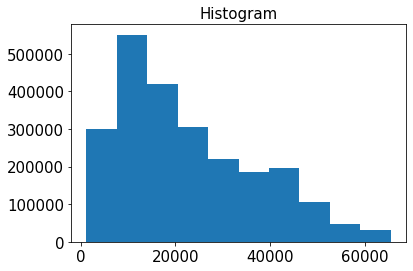

In [5]:
vis_tb = xr.open_rasterio(visible)

vis_tb.plot();

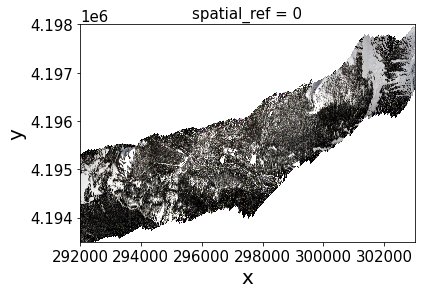

In [6]:
vis = rioxarray.open_rasterio(visible)

vis.plot.imshow(robust=True);

# Why is this grayscale? Also how it shows up in QGIS and I'm so confused

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


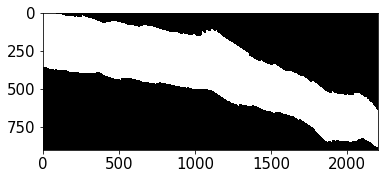

In [7]:
red = vis.sel(band=1)
green = vis.sel(band=2)
blue = vis.sel(band=3)

rgb = np.dstack([red,green,blue])
plt.imshow(rgb);

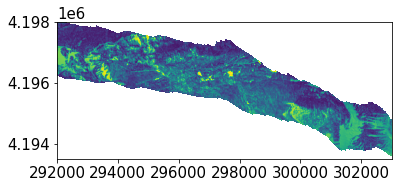

<AxesSubplot:>

In [8]:
src = rasterio.open(visible)
rasterio.plot.show(src)

In [9]:
# Read in ASTER and convert to brightness temperature using xarray and aster_processing_fn
aster_src = xr.open_rasterio(aster_tif)
aster_band = 14
aster_rad = aster_processing_fn.tir_dn2rad(aster_src, aster_band)
aster_tb = aster_processing_fn.tir_rad2tb(aster_rad, aster_band)
# Convert to degC
aster_tb_degC = aster_tb-273.15
aster_tb_degC.rio.set_crs(aster_src.crs)

# Read in Airborne
air_tb = xr.open_rasterio(airborne_tif)
air_tb_K = air_tb+273.15

C:\Users\CALIR\Anaconda3\envs\uwgda2021\lib\site-packages\xarray\core\computation.py:724: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [10]:
def tb_to_rad(temps,wl):
    c1 = 1.191042e8
    c2 = 1.4387752e4
    rads = c1 / (wl**5 * (np.exp(c2/(wl*temps))-1))
    return rads

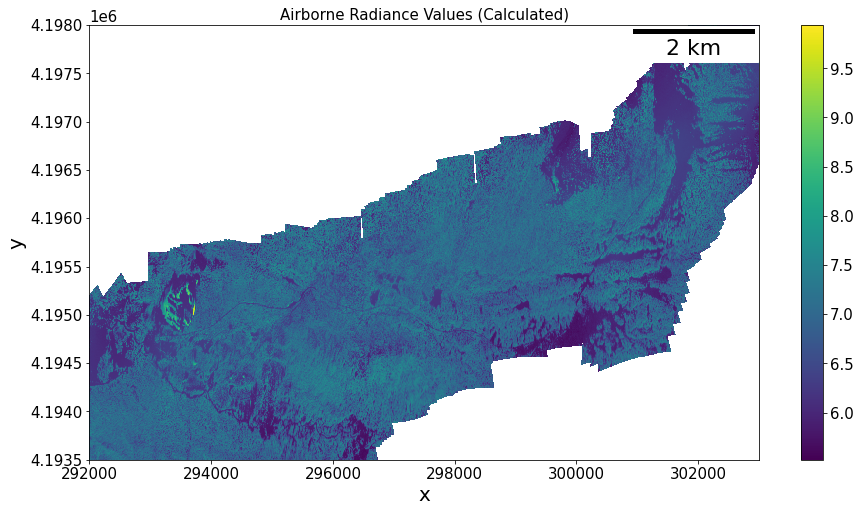

In [11]:
#air_rad_numpy = planck(0.000011, air_tb_K, wavelength=True)
#air_rad = xr.DataArray(air_rad_numpy.values, air_tb.coords)
#air_rad = air_rad.rio.set_crs(air_tb.crs)

air_rad = tb_to_rad(air_tb_K,11)
air_rad = air_rad.rio.set_crs(air_tb.crs)

f, ax = plt.subplots(figsize=(15,8))
air_rad.plot()
ax.add_artist(ScaleBar(1.0))
ax.set_title('Airborne Radiance Values (Calculated)');

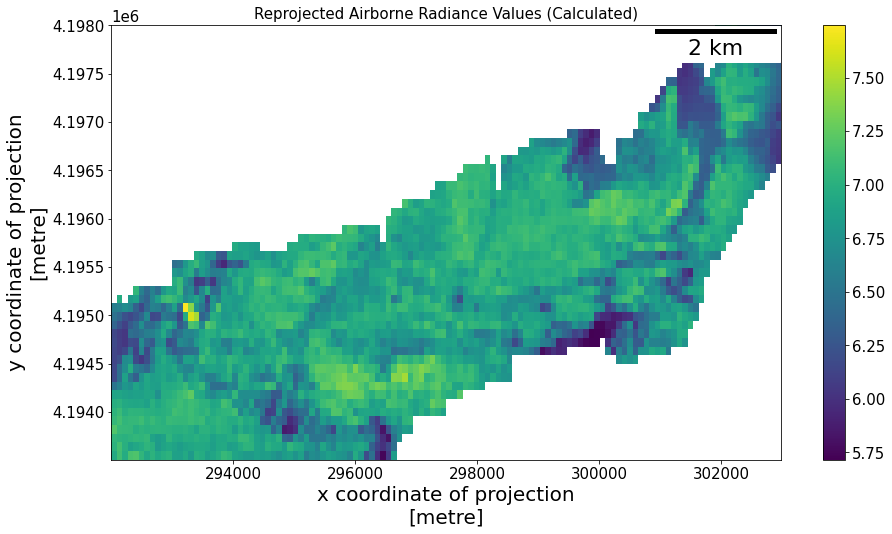

In [12]:
air_rad_repr = air_rad.rio.reproject_match(aster_src, resampling=5)

air_rad_repr = air_rad_repr.where(air_rad_repr != air_rad_repr.attrs['_FillValue'],drop=True)

f, ax = plt.subplots(figsize=(15,8))
air_rad_repr.plot()
ax.add_artist(ScaleBar(1.0))
ax.set_title('Reprojected Airborne Radiance Values (Calculated)');

In [13]:
def rad_to_tb(rads,wl):
    c1 = 1.191042e8
    c2 = 1.4387752e4
    temps = c2 / (wl * (np.log(c1/(wl**5 * rads)+1)))
    return temps

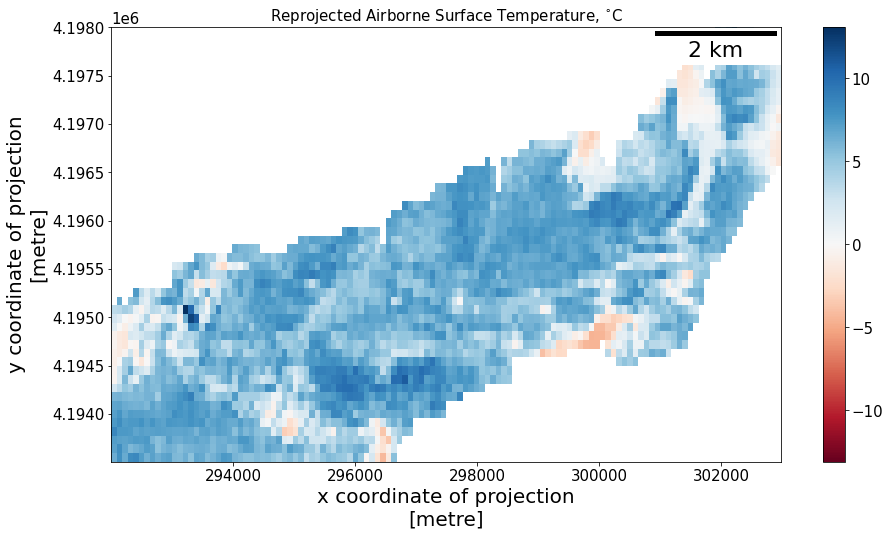

In [14]:
# Convert everything back
air_tb_K_repr = rad_to_tb(air_rad_repr, 11)
air_tb_repr = air_tb_K_repr - 273.15

f, ax = plt.subplots(figsize=(15,8))
air_tb_repr.plot(cmap='RdBu')
ax.add_artist(ScaleBar(1.0))
ax.set_title('Reprojected Airborne Surface Temperature, $^{\circ}$C');

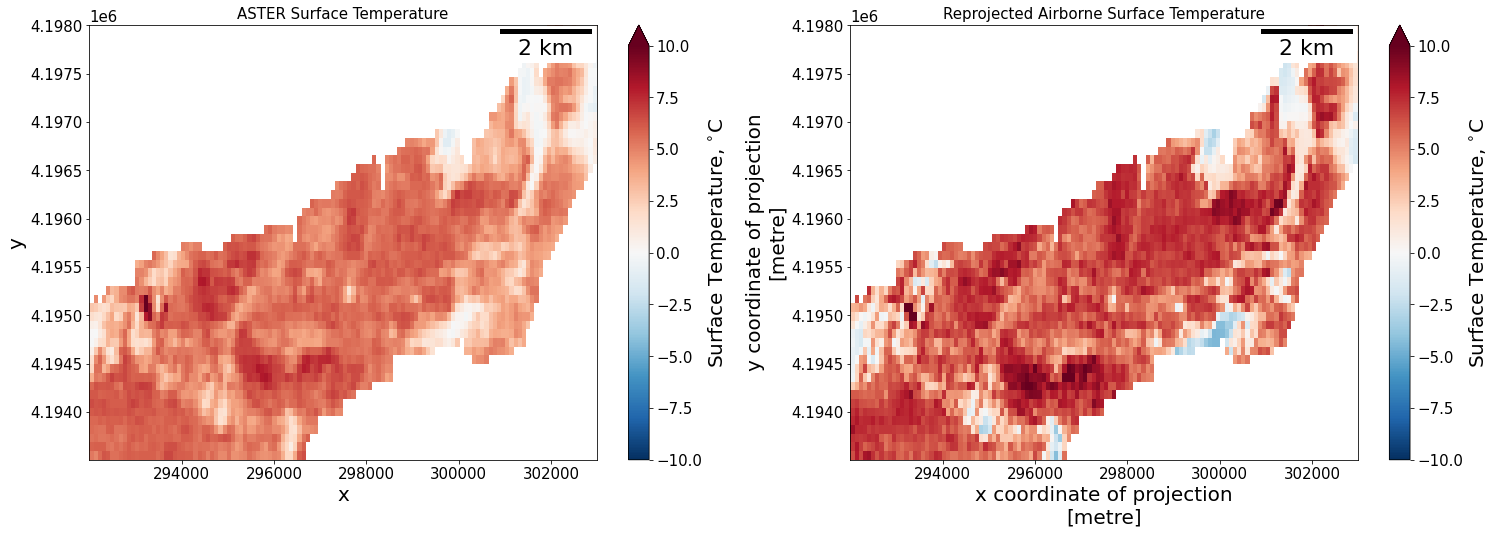

In [15]:
# Mask ASTER to study area
aster_tb_masked = aster_tb_degC.where(~np.isnan(air_tb_repr),drop=True)

# Plot both datasets
f, ax = plt.subplots(1,2,figsize=(25,8))

aster_tb_masked.plot(cmap='RdBu_r', cbar_kwargs={'label': 'Surface Temperature, $^{\circ}$C'},vmin=-10,vmax=10, ax=ax[0])
ax[0].add_artist(ScaleBar(1.0))
ax[0].set_title('ASTER Surface Temperature')

air_tb_repr.plot(cmap='RdBu_r', cbar_kwargs={'label': 'Surface Temperature, $^{\circ}$C'},vmin=-10,vmax=10,ax=ax[1])
ax[1].add_artist(ScaleBar(1.0))
ax[1].set_title('Reprojected Airborne Surface Temperature');

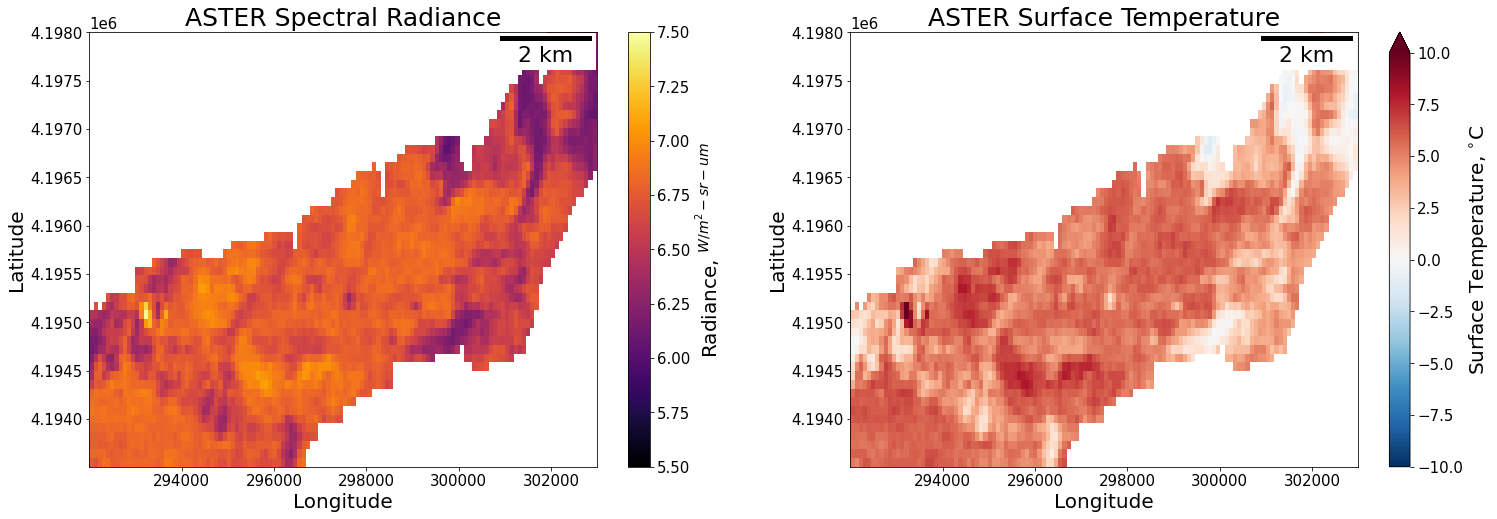

In [203]:
aster_rad_m = aster_rad.where(~np.isnan(air_tb_repr),drop=True)

# Plot ASTER radiance and surface temperature
f, ax = plt.subplots(1,2,figsize=(25,8))

aster_rad_m.plot(cmap='inferno', cbar_kwargs={'label': 'Radiance, $^{W/m^2-sr-um}$'},ax=ax[0], vmin=5.5,vmax=7.5)
ax[0].add_artist(ScaleBar(1.0))
ax[0].set_title('ASTER Spectral Radiance',fontsize=25)
ax[0].set_xlabel('Longitude',fontsize=20)
ax[0].set_ylabel('Latitude',fontsize=20)

aster_tb_masked.plot(cmap='RdBu_r', cbar_kwargs={'label': 'Surface Temperature, $^{\circ}$C'}, ax=ax[1], vmin=-10, vmax=10)
ax[1].add_artist(ScaleBar(1.0))
ax[1].set_title('ASTER Surface Temperature',fontsize=25)
ax[1].set_xlabel('Longitude',fontsize=20)
ax[1].set_ylabel('Latitude',fontsize=20);

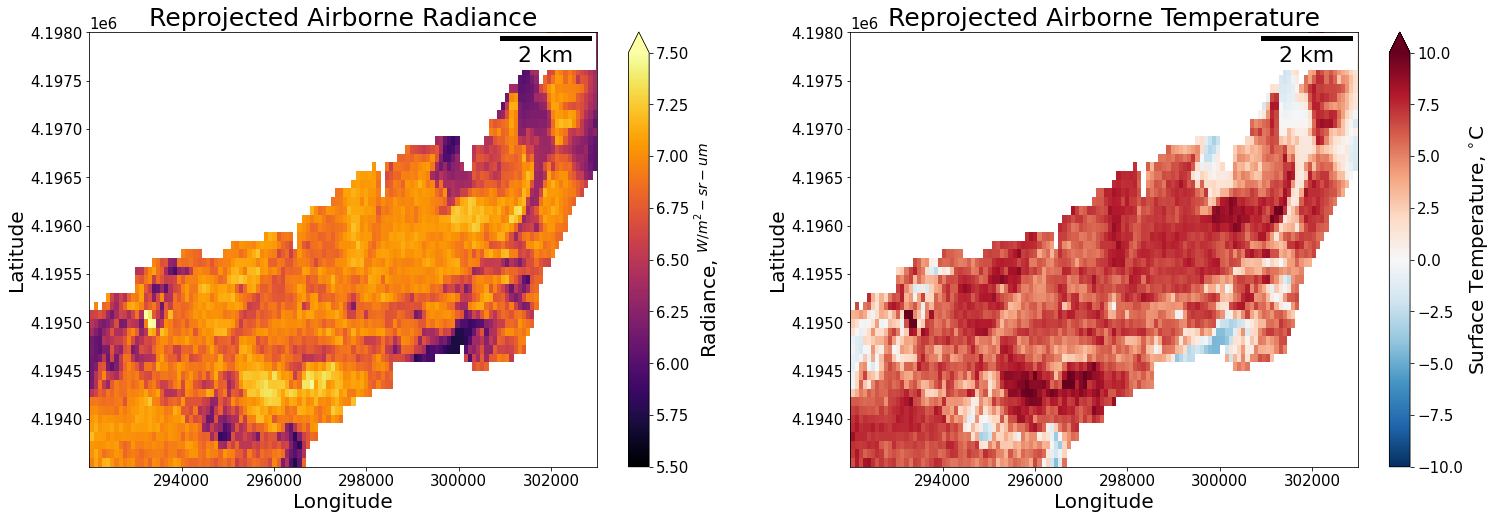

In [208]:
# Plot airborne radiance and surface temperature
f, ax = plt.subplots(1,2,figsize=(25,8))

air_rad_repr.plot(cmap='inferno', cbar_kwargs={'label': 'Radiance, $^{W/m^2-sr-um}$'},ax=ax[0], vmin=5.5, vmax=7.5)
ax[0].add_artist(ScaleBar(1.0))
ax[0].set_title('Reprojected Airborne Radiance',fontsize=25)
ax[0].set_xlabel('Longitude',fontsize=20)
ax[0].set_ylabel('Latitude',fontsize=20)

air_tb_repr.plot(cmap='RdBu_r', cbar_kwargs={'label': 'Surface Temperature, $^{\circ}$C'}, ax=ax[1], vmin=-10,vmax=10)
ax[1].add_artist(ScaleBar(1.0))
ax[1].set_title('Reprojected Airborne Temperature',fontsize=25)
ax[1].set_xlabel('Longitude',fontsize=20)
ax[1].set_ylabel('Latitude',fontsize=20);

In [ ]:
# Plot airborne radiance and surface temperature reprojected
f, ax = plt.subplots(1,2,figsize=(25,8))

air_rad.plot(cmap='inferno', cbar_kwargs={'label': 'Radiance, $^{W/m^2-sr-um}$'},ax=ax[1], vmin=5.5, vmax=7.5)
ax[1].add_artist(ScaleBar(1.0))
ax[1].set_title('Airborne Spectral Radiance',fontsize=25)
ax[1].set_xlabel('Longitude',fontsize=20)
ax[1].set_ylabel('Latitude',fontsize=20)

air_tb.plot(cmap='RdBu_r', cbar_kwargs={'label': 'Surface Temperature, $^{\circ}$C'}, ax=ax[0], vmin=-10,vmax=10)
ax[0].add_artist(ScaleBar(1.0))
ax[0].set_title('Airborne Surface Temperature',fontsize=25)
ax[0].set_xlabel('Longitude',fontsize=20)
ax[0].set_ylabel('Latitude',fontsize=20);

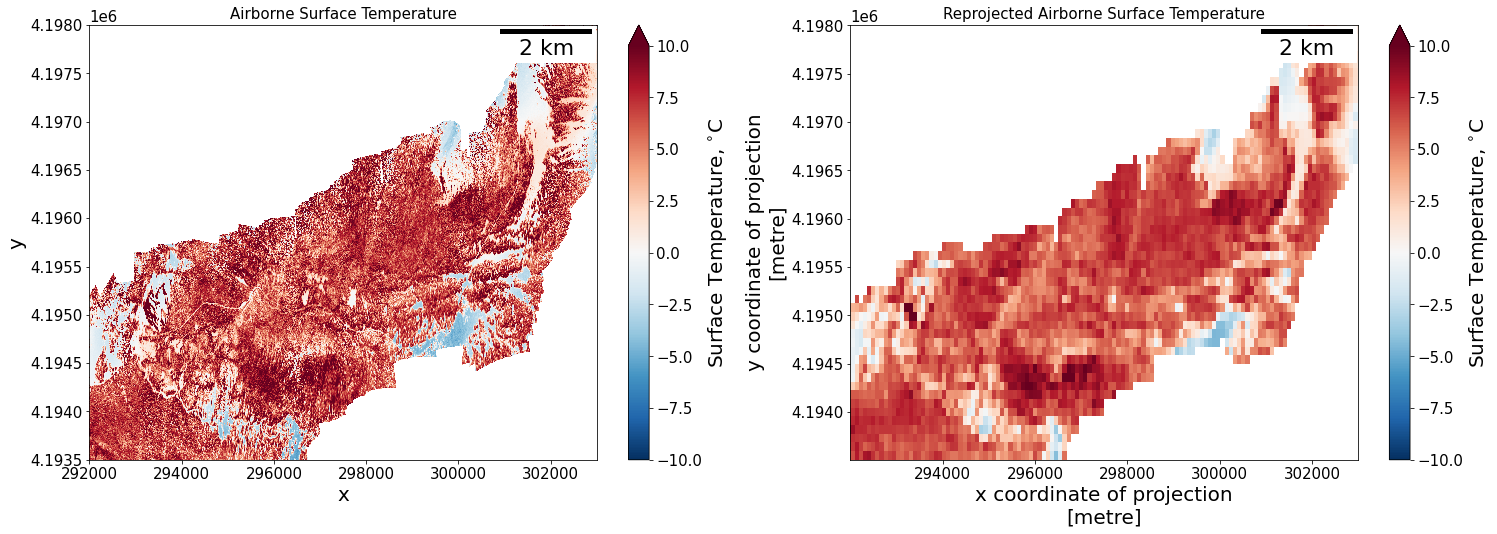

In [16]:
# Mask ASTER to study area
aster_tb_masked = aster_tb_degC.where(~np.isnan(air_tb_repr),drop=True)

# Plot both datasets
f, ax = plt.subplots(1,2,figsize=(25,8))

air_tb.plot(cmap='RdBu_r', cbar_kwargs={'label': 'Surface Temperature, $^{\circ}$C'},vmin=-10,vmax=10, ax=ax[0])
ax[0].add_artist(ScaleBar(1.0))
ax[0].set_title('Airborne Surface Temperature')

air_tb_repr.plot(cmap='RdBu_r', cbar_kwargs={'label': 'Surface Temperature, $^{\circ}$C'},vmin=-10,vmax=10,ax=ax[1])
ax[1].add_artist(ScaleBar(1.0))
ax[1].set_title('Reprojected Airborne Surface Temperature');

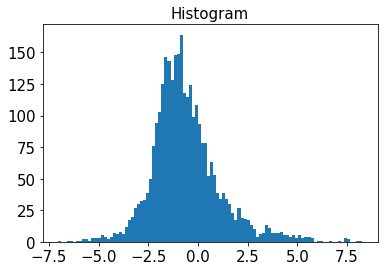

In [17]:
diff = aster_tb_masked - air_tb_repr
diff.plot.hist(bins=100);

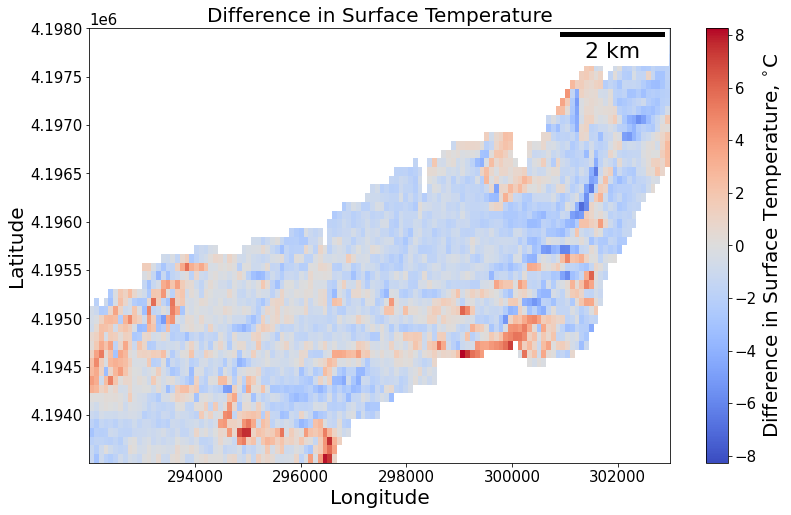

In [213]:
f, ax = plt.subplots(figsize=(13,8))
diff.plot(cmap='coolwarm',cbar_kwargs={'label': 'Difference in Surface Temperature, $^{\circ}$C'},)
ax.add_artist(ScaleBar(1.0))
ax.set_title('Difference in Surface Temperature',fontsize=20)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude');

In [19]:
# Calculate statistics of difference map
mean_diff = diff.mean().item(0)
median_diff = diff.median().item(0)
std_diff = diff.std().item(0)
max_diff = abs(diff).max().item(0)

print('Mean Difference = ', np.round(mean_diff,3))
print('Median Difference = ', np.round(median_diff,3))
print('Standard Devation of Differences = ', np.round(std_diff,3))
print('Maximum Difference = ', np.round(max_diff,3))

Mean Difference =  -0.614
Median Difference =  -0.855
Standard Devation of Differences =  1.731
Maximum Difference =  8.266


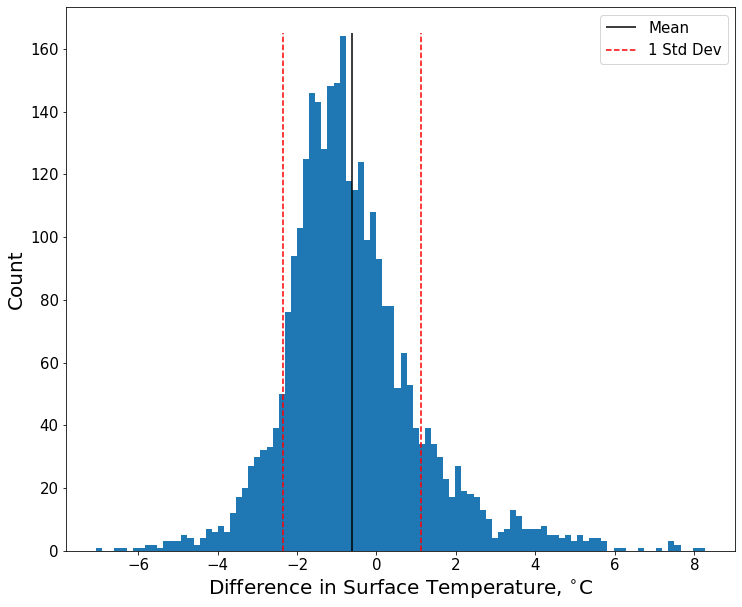

In [20]:
# Plot histogram of differences
f, ax = plt.subplots(figsize=(12,10))

plt.hist(diff.values.ravel(),bins=100)

# Plot vline at mean
ax.vlines(mean_diff, ymin=0, ymax=165, color='k', label='Mean')

# Plot vline at +- 1stdev
x_stdev = [mean_diff+std_diff, mean_diff-std_diff]
ax.vlines(x_stdev, ymin=0, ymax=165, color='r', linestyles='dashed', label='1 Std Dev')

plt.legend()

ax.set_xlabel('Difference in Surface Temperature, $^{\circ}$C')
ax.set_ylabel('Count');

In [21]:
# Identify red and near infrared images
red_path = './images/AST_L1T_00304212017185107_20170422082541_26960_ImageData2.tif'
nir_path = './images/AST_L1T_00304212017185107_20170422082541_26960_ImageData3N.tif'

In [22]:
# Pull red, nir and mask
red_src = xr.open_rasterio(red_path)
nir_src = xr.open_rasterio(nir_path)

red_m = red_src.where(~np.isnan(air_tb_repr),drop=True)
nir_m = nir_src.where(~np.isnan(air_tb_repr),drop=True)

In [23]:
# Calculate NDVI
NDVI = (nir_m-red_m)/(nir_m+red_m)

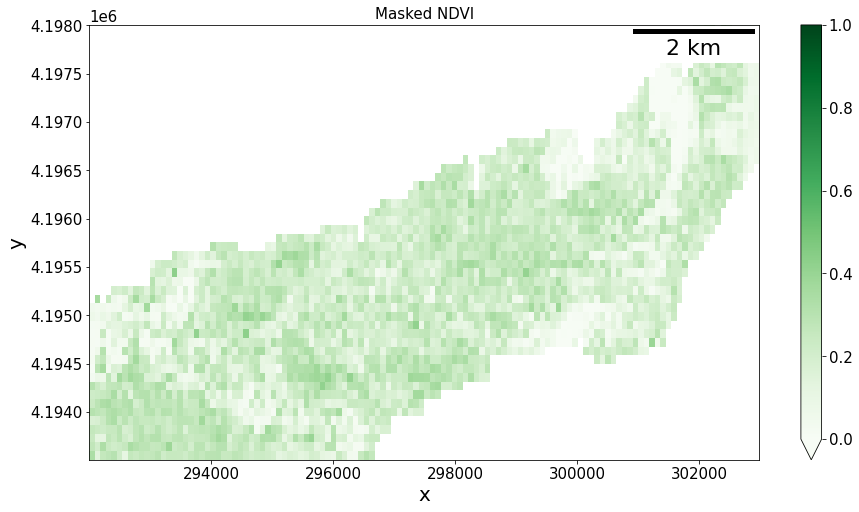

In [24]:
# Plot NDVI
f, ax = plt.subplots(figsize=(15,8))
NDVI.plot(ax=ax, vmin=0, vmax=1,cmap='Greens')
ax.add_artist(ScaleBar(1.0))
ax.set_title('Masked NDVI');

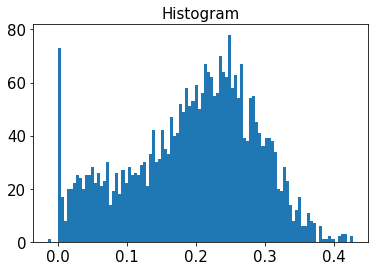

In [25]:
NDVI.plot.hist(bins=100);

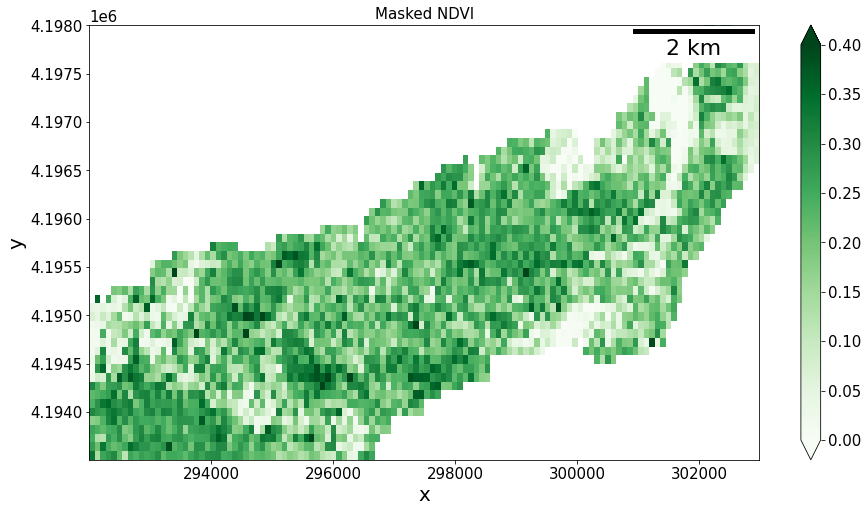

In [26]:
# Plot NDVI
f, ax = plt.subplots(figsize=(15,8))
NDVI.plot(ax=ax, vmin=0, vmax=0.4,cmap='Greens')
ax.add_artist(ScaleBar(1.0))
ax.set_title('Masked NDVI');

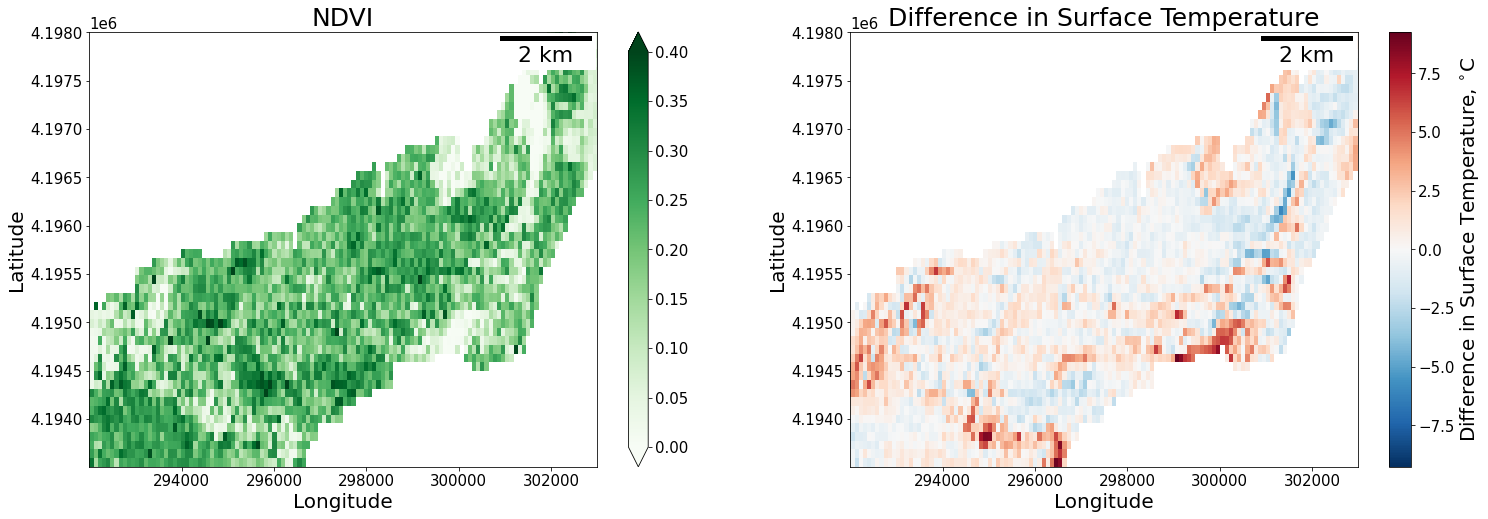

In [216]:
# Plot airborne radiance and surface temperature
f, ax = plt.subplots(1,2,figsize=(25,8))

NDVI.plot(cmap='Greens', ax=ax[0], vmin=0, vmax=0.4)
ax[0].add_artist(ScaleBar(1.0))
ax[0].set_title('NDVI',fontsize=25)
ax[0].set_xlabel('Longitude',fontsize=20)
ax[0].set_ylabel('Latitude',fontsize=20)

diff_corr.plot(cmap='RdBu_r', cbar_kwargs={'label': 'Difference in Surface Temperature, $^{\circ}$C'}, ax=ax[1])
ax[1].add_artist(ScaleBar(1.0))
ax[1].set_title('Difference in Surface Temperature',fontsize=25)
ax[1].set_xlabel('Longitude',fontsize=20)
ax[1].set_ylabel('Latitude',fontsize=20);

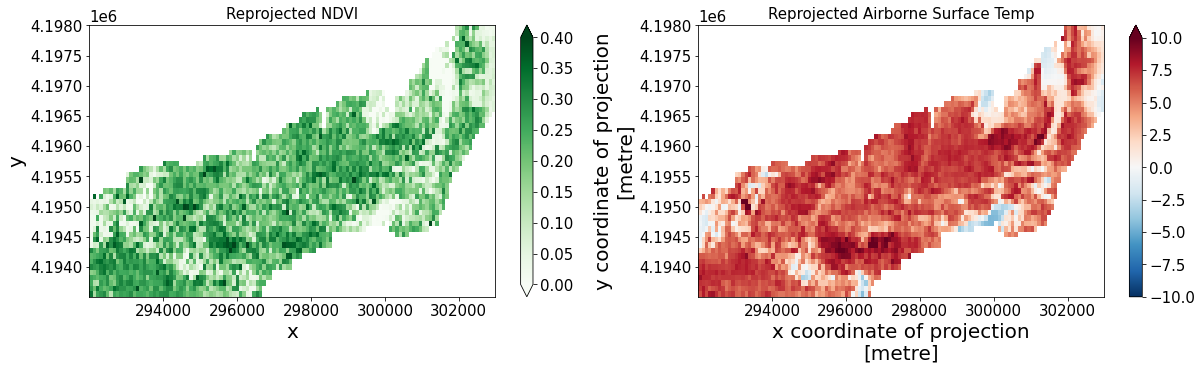

In [28]:
f, [ax1, ax2] = plt.subplots(1,2)

NDVI.plot(ax=ax1, vmin=0, vmax=.4, cmap='Greens')
ax1.set_title('Reprojected NDVI')
air_tb_repr.plot(ax=ax2, vmin=-10, vmax=10, cmap='RdBu_r')
ax2.set_title('Reprojected Airborne Surface Temp')

f.set_figwidth(20)
f.set_figheight(5);

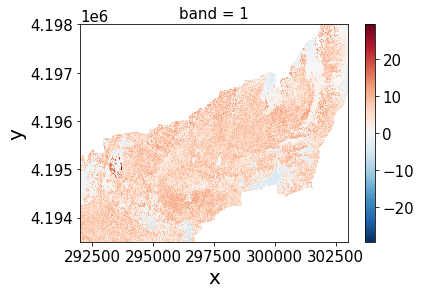

In [29]:
air_tb.plot()

In [30]:
min_lon = 294000
min_lat = 4194500
max_lon = 294180
max_lat = 4194760

air_clipped = air_tb.rio.clip_box(
    min_lon,
    min_lat,
    max_lon,
    max_lat,
)

ast_clipped = aster_tb_degC.rio.clip_box(
    min_lon,
    min_lat,
    max_lon,
    max_lat,
)

In [170]:
min_lon = 301280
min_lat = 4196580
max_lon = 302080
max_lat = 4197370

air_clipped = air_tb.rio.clip_box(
    min_lon,
    min_lat,
    max_lon,
    max_lat,
)

ast_clipped = aster_tb_degC.rio.clip_box(
    min_lon,
    min_lat,
    max_lon,
    max_lat,
)

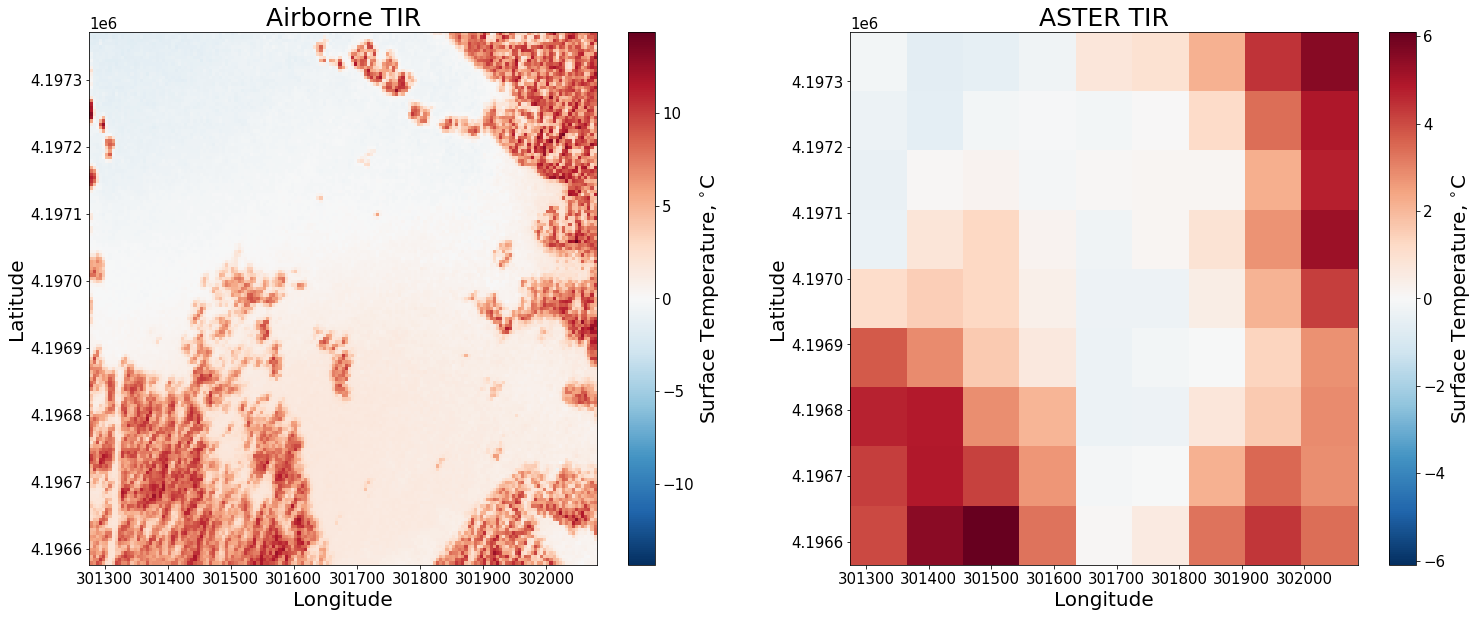

In [186]:
# Plot both datasets
f, ax = plt.subplots(1,2,figsize=(25,9.8))

air_clipped.plot(cmap='RdBu_r', cbar_kwargs={'label': 'Surface Temperature, $^{\circ}$C'},ax=ax[0])
#ax[0].add_artist(ScaleBar(1.0))
ax[0].set_title('Airborne TIR', fontsize=25)
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

ast_clipped.plot(cmap='RdBu_r', cbar_kwargs={'label': 'Surface Temperature, $^{\circ}$C'},ax=ax[1])
#ax[1].add_artist(ScaleBar(1.0))
ax[1].set_title('ASTER TIR', fontsize=25)
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude');

In [34]:
NDVI_m = NDVI.values[~np.isnan(NDVI.values)]
diff_m = diff.values[~np.isnan(diff.values)]

In [35]:
slope, intercept, rvalue, pvalue, stderr = stats.linregress(NDVI_m, diff_m)

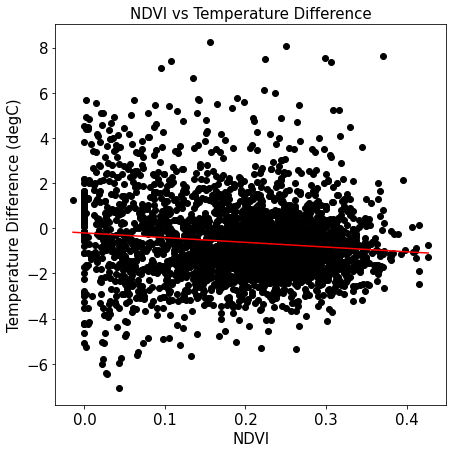

In [36]:
# Plot scatterplot
fig, ax = plt.subplots(figsize=(7,7))
plt.scatter(x=NDVI_m, y=diff_m, c='k');
ax.set_title('NDVI vs Temperature Difference')
ax.set_xlabel('NDVI', fontsize=15)
ax.set_ylabel('Temperature Difference (degC)', fontsize=15)

x = np.linspace(NDVI_m.min(), NDVI_m.max(), NDVI_m.size) # x coordinates from min and max values
y = slope * x + intercept 

# Plot the regression line
ax.plot(x, y, '-r')


In [37]:
print('R^2 = ', rvalue**2)

R^2 =  0.012236345433990147


In [38]:
print('Slope = ', slope)

Slope =  -2.0858502003466577


In [39]:
print('p-value = ', pvalue)

p-value =  1.0932995280542356e-09


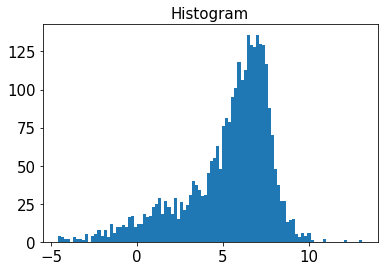

In [40]:
# Check around Dana Meadows
air_tb_repr.plot.hist(bins=100);

In [229]:
diff_corr = diff+1

In [230]:
# Zoom in on Dana Meadows

min_lon = 301250
min_lat = 4195900
max_lon = 302130
max_lat = 4197500

air_DANA = air_tb.rio.clip_box(
    min_lon,
    min_lat,
    max_lon,
    max_lat,
)

diff_DANA = diff_corr.rio.clip_box(
    min_lon,
    min_lat,
    max_lon,
    max_lat,
)

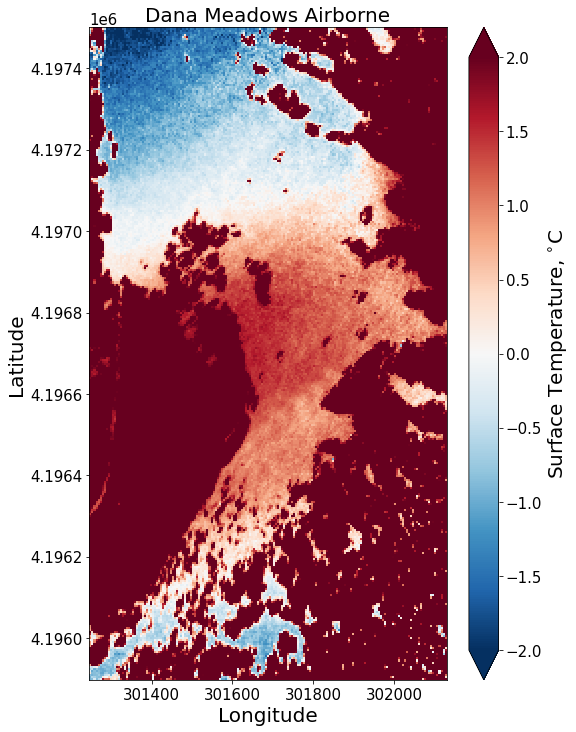

In [231]:
f,ax = plt.subplots(figsize=(8,12))

air_DANA.plot(cmap='RdBu_r', cbar_kwargs={'label': 'Surface Temperature, $^{\circ}$C'},ax=ax,vmin=-2,vmax=2)
#ax[0].add_artist(ScaleBar(1.0))
ax.set_title('Dana Meadows Airborne', fontsize=20)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude');

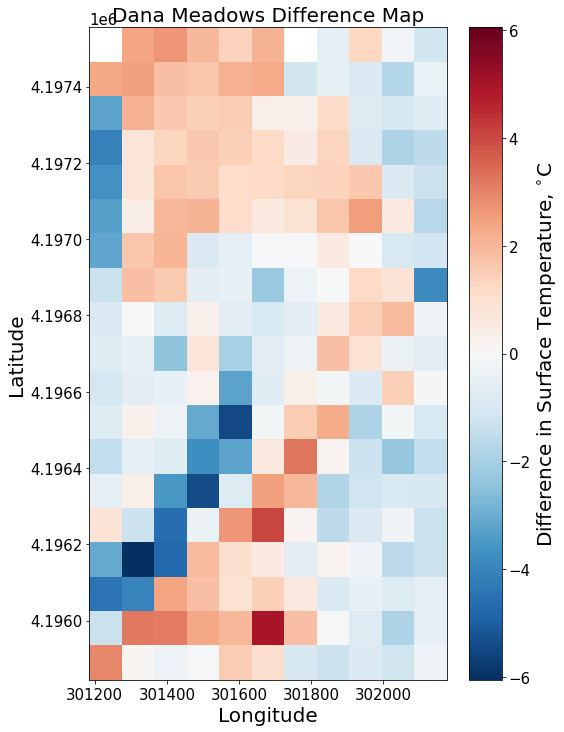

In [234]:
f,ax = plt.subplots(figsize=(8,12))

diff_DANA.plot(cmap='RdBu_r', cbar_kwargs={'label': 'Difference in Surface Temperature, $^{\circ}$C'},ax=ax)
#ax.add_artist(ScaleBar(1.0))
ax.set_title('Dana Meadows Difference Map', fontsize=20)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude');

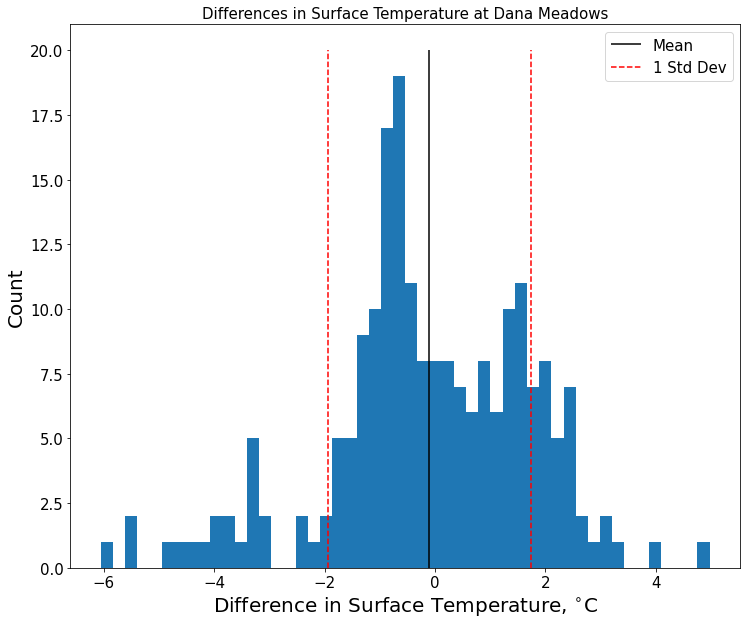

In [233]:
# Plot histogram of differences
f, ax = plt.subplots(figsize=(12,10))

plt.hist(diff_DANA.values.ravel(),bins=50)

# Plot vline at mean
ax.vlines(diff_DANA.mean(), ymin=0, ymax=20, color='k', label='Mean')

# Plot vline at +- 1stdev
x_stdev = [diff_DANA.mean()+diff_DANA.std(), diff_DANA.mean()-diff_DANA.std()]
ax.vlines(x_stdev, ymin=0, ymax=20, color='r', linestyles='dashed', label='1 Std Dev')

plt.legend()

ax.set_xlabel('Difference in Surface Temperature, $^{\circ}$C')
ax.set_ylabel('Count')
ax.set_title('Differences in Surface Temperature at Dana Meadows');

In [235]:
# Zoom in on Gaylor Pit

min_lon = 296600
min_lat = 4195100
max_lon = 296775
max_lat = 4195275

air_GAYLOR = air_tb.rio.clip_box(
    min_lon,
    min_lat,
    max_lon,
    max_lat,
)

diff_GAYLOR = diff_corr.rio.clip_box(
    min_lon,
    min_lat,
    max_lon,
    max_lat,
)

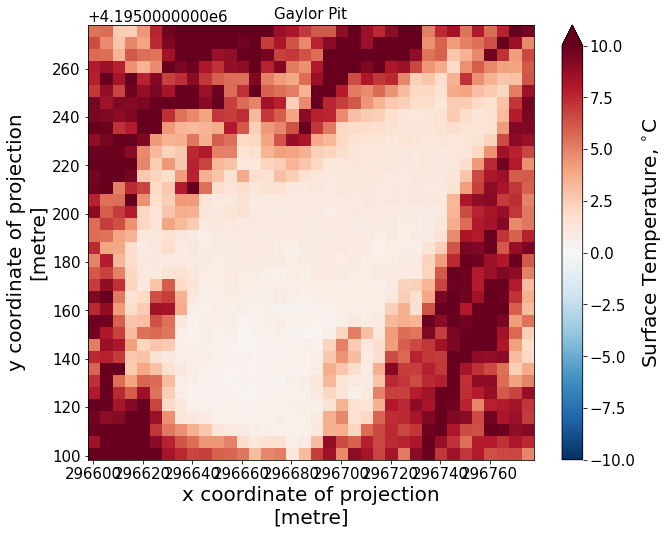

In [240]:
f,ax = plt.subplots(figsize=(10,8))

air_GAYLOR.plot(cmap='RdBu_r', cbar_kwargs={'label': 'Surface Temperature, $^{\circ}$C'},ax=ax, vmin=-10,vmax=10)
#ax[0].add_artist(ScaleBar(1.0))
ax.set_title('Gaylor Pit', fontsize=15);

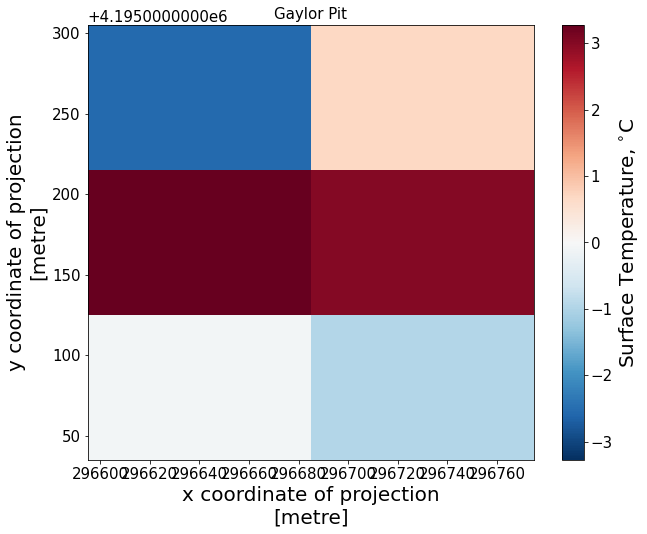

In [238]:
f,ax = plt.subplots(figsize=(10,8))

diff_GAYLOR.plot(cmap='RdBu_r', cbar_kwargs={'label': 'Surface Temperature, $^{\circ}$C'},ax=ax)
#ax[0].add_artist(ScaleBar(1.0))
ax.set_title('Gaylor Pit', fontsize=15);

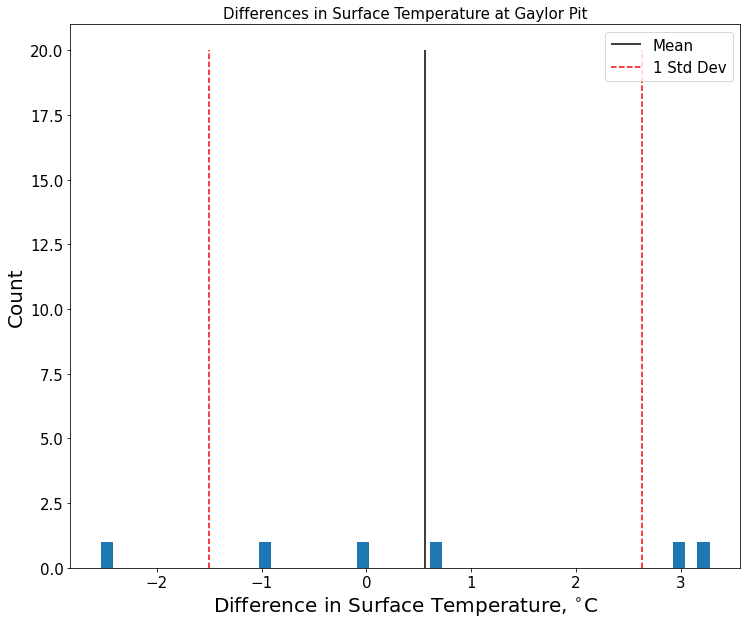

In [237]:
# Plot histogram of differences
f, ax = plt.subplots(figsize=(12,10))

plt.hist(diff_GAYLOR.values.ravel(),bins=50)

# Plot vline at mean
ax.vlines(diff_GAYLOR.mean(), ymin=0, ymax=20, color='k', label='Mean')

# Plot vline at +- 1stdev
x_stdev = [diff_GAYLOR.mean()+diff_GAYLOR.std(), diff_GAYLOR.mean()-diff_GAYLOR.std()]
ax.vlines(x_stdev, ymin=0, ymax=20, color='r', linestyles='dashed', label='1 Std Dev')

plt.legend()

ax.set_xlabel('Difference in Surface Temperature, $^{\circ}$C')
ax.set_ylabel('Count')
ax.set_title('Differences in Surface Temperature at Gaylor Pit');

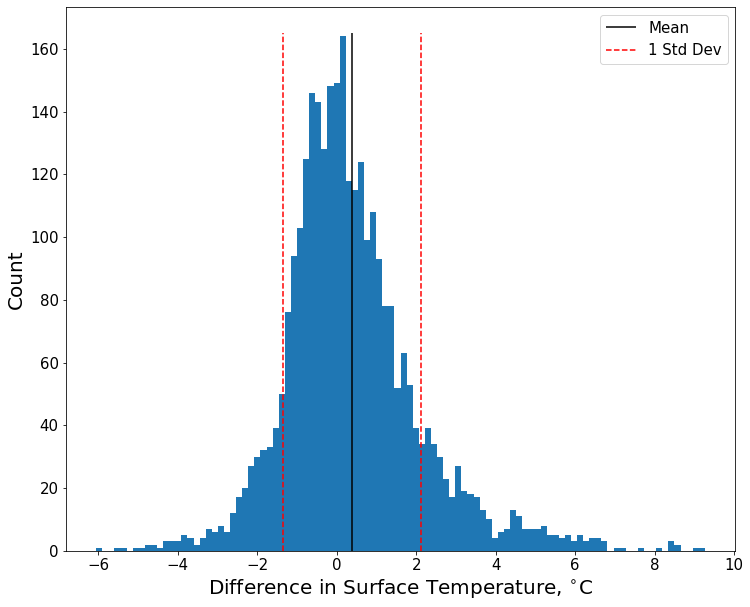

In [88]:
# Plot histogram of differences
f, ax = plt.subplots(figsize=(12,10))

plt.hist(diff_corr.values.ravel(),bins=100)

# Plot vline at mean
ax.vlines(mean_diff_c, ymin=0, ymax=165, color='k', label='Mean')

# Plot vline at +- 1stdev
x_stdev = [mean_diff_c+std_diff_c, mean_diff_c-std_diff_c]
ax.vlines(x_stdev, ymin=0, ymax=165, color='r', linestyles='dashed', label='1 Std Dev')

plt.legend()

ax.set_xlabel('Difference in Surface Temperature, $^{\circ}$C')
ax.set_ylabel('Count');